### Prepare transform module for training

In [42]:
root="/workspace/ImageNet/ImageNet-S/ImageNetS919"

In [43]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import torchvision
import torchvision.transforms as transforms

# path settings
PROJECT_PATH = '/workspace/Moon_Pattern_Inference'
DIR_IMAGENETS = "/workspace/ImageNet/ImageNet-S/ImageNetS919"

# impor module
sys.path.append(PROJECT_PATH)
import silhouette_model.utils as utils

In [44]:
def load_image(name:str=""):
    filein_segmentation=f"{DIR_IMAGENETS}/train-semi-segmentation/{name}.png"
    img = pil_loader(filein_segmentation)
    return img

def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

In [45]:
name="n01440764/n01440764_2803"

img=load_image(name=name)

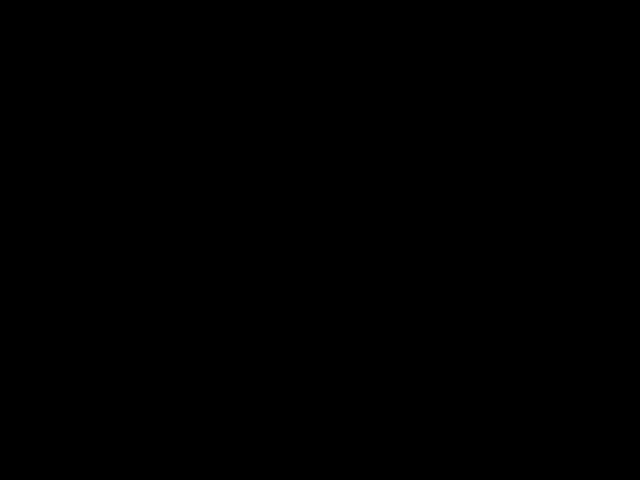

In [16]:
img

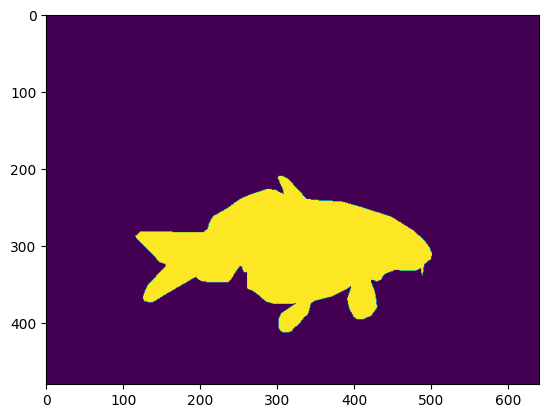

In [47]:
segmentation=np.array(img)
segmentation=segmentation[:,:,1]*256+segmentation[:,:,0]
plt.imshow(segmentation)

In [48]:
np.array([segmentation]*3).transpose((1,2,0)).shape

(480, 640, 3)

In [68]:
class Transforms_Segmentation:
    def __init__(self) -> None:
        pass

    def __call__(self, img: Image.Image) -> Image.Image:
        x=np.array(img)
        x=x[:,:,1]*256+x[:,:,0] #0 for nothing, id (int) for tile
        x=np.array([x]*3, dtype=np.uint8).transpose((1,2,0)) # reshape (size,size)→(size,size,3)
        return Image.fromarray(x)

In [69]:
img2=Transforms_Segmentation()(img)

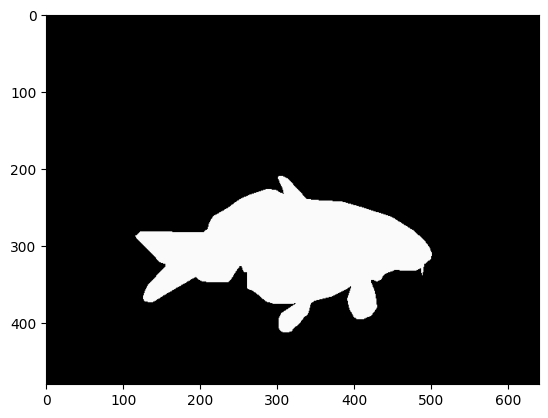

In [73]:
plt.imshow(np.array(img2)*250)

In [80]:
def set_transforms():
    # normalization
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
    # for training dataset
    train_data_transform = transforms.Compose([
        transforms.Resize((256,256)),
        Transforms_Segmentation(),
        transforms.RandomHorizontalFlip(p=0.5),
        utils.random_rotation_transform(rr_prob=1., rr_degrees=[0,180]),
        #transforms.RandomApply([
        #    transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)], p=0.8
        #    ), # don't need color jitter for silhouette
        #transforms.RandomGrayscale(p=0.2), # don't need grey scaling for silhouette
        #transforms.RandomApply([
        #    transforms.GaussianBlur((3, 3), (1.0, 2.0))], p=0.2
        #    ), # don't need blur for silhouette
        transforms.RandomResizedCrop((224, 224)),
        transforms.ToTensor(),
        normalize
    ])
    # for validation dataset
    val_data_transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        normalize
    ])
    return train_data_transform, val_data_transform